### Brief Description of the Problem and Data
#### Problem Description
The Kaggle competition titled "I’m Something of a Painter Myself" challenges participants to use Generative Adversarial Networks (GANs) to generate images in the style of Claude Monet. The task involves creating 7,000 to 10,000 images that mimic the unique style of Monet's paintings. The GAN framework consists of two neural networks: a generator and a discriminator. The generator creates the Monet-style images, while the discriminator tries to distinguish between real Monet paintings and the generated ones. The goal is to train the GAN in such a way that the generator produces convincing Monet-style images that can trick the discriminator.

#### Data Description
The dataset contains four main directories, each with images sized 256x256 pixels:
- monet_jpg: 300 Monet paintings in JPEG format.
- monet_tfrec: 300 Monet paintings in TFRecord format.
- photo_jpg: 7,028 photos in JPEG format.
- photo_tfrec: 7,028 photos in TFRecord format.
Participants can choose to work with either the JPEG or TFRecord formats. The Monet directories contain the paintings used to train the GAN, while the photo directories contain the photos that need to be transformed into Monet-style images.

### Exploratory Data Analysis (EDA)
#### Inspecting the Data
We begin by loading and inspecting the data to understand its structure and contents.

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define the paths
monet_jpg_path = 'data/monet_jpg/'
photo_jpg_path = 'data/photo_jpg/'

# List the files in the directories
monet_files = os.listdir(monet_jpg_path)
photo_files = os.listdir(photo_jpg_path)

print(f'Number of Monet paintings: {len(monet_files)}')
print(f'Number of Landscape photos: {len(photo_files)}')

Number of Monet paintings: 300
Number of Landscape photos: 7038


#### Visualizing the Data
Next, we visualize a few samples from each dataset to get an idea of the images.

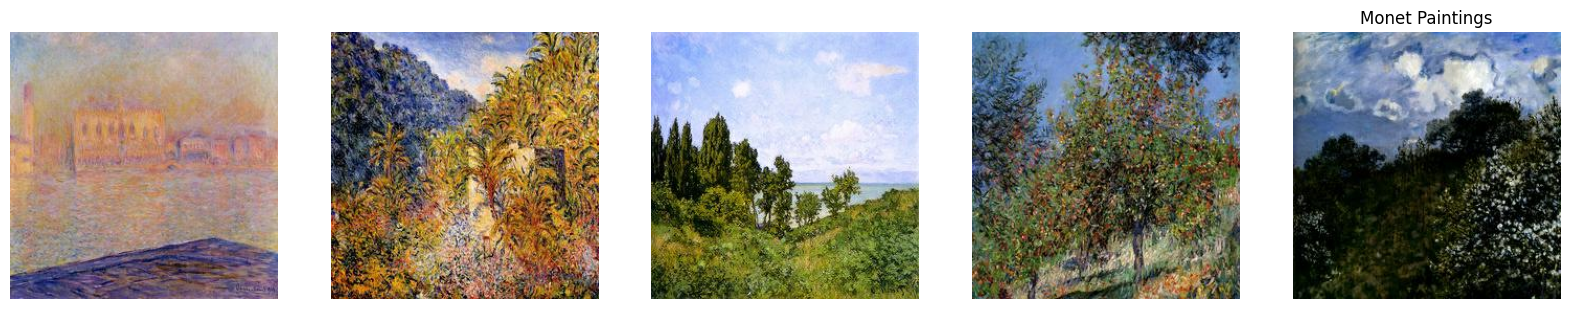

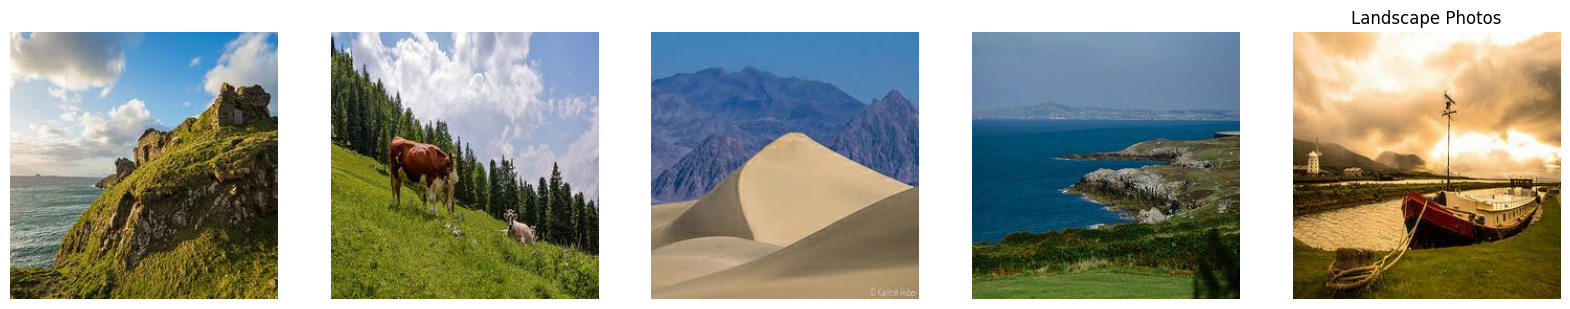

In [2]:
# Display some Monet paintings
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for ax, file in zip(axes, monet_files[:5]):
    img = Image.open(os.path.join(monet_jpg_path, file))
    ax.imshow(img)
    ax.axis('off')
ax.set_title('Monet Paintings')
plt.show()

# Display some Landscape photos
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for ax, file in zip(axes, photo_files[:5]):
    img = Image.open(os.path.join(photo_jpg_path, file))
    ax.imshow(img)
    ax.axis('off')
ax.set_title('Landscape Photos')
plt.show()

#### Data Cleaning
The dataset appears to be well-structured and clean. However, we ensure all images are of the correct size and format.

In [3]:
def check_image_dimensions(files, path, expected_size=(256, 256)):
    for file in files:
        img = Image.open(os.path.join(path, file))
        if img.size != expected_size:
            print(f'Image {file} has size {img.size}')

# Check dimensions for both datasets
check_image_dimensions(monet_files, monet_jpg_path)
check_image_dimensions(photo_files, photo_jpg_path)

## Model Building and Training
#### Import Libraries and Define Helper Functions
First, we need to import the necessary libraries and define any helper functions required for data processing and visualization.

In [14]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import os
import time

# Set some constants
IMG_HEIGHT = 256
IMG_WIDTH = 256
BUFFER_SIZE = 1000
BATCH_SIZE = 1

# Function to load and preprocess images
def load_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = (image / 127.5) - 1
    return image

# Function to load dataset
def load_dataset(path):
    dataset = tf.data.Dataset.list_files(path)
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

# Load datasets
monet_ds = load_dataset('data/monet_jpg/*.jpg')
photo_ds = load_dataset('data/photo_jpg/*.jpg')

#### Define the Generator and Discriminator Models

In [7]:
# Function to create the generator model
def Generator():
    inputs = layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])
    
    down_stack = [
        layers.Conv2D(64, 4, strides=2, padding='same', use_bias=False, kernel_initializer='he_normal'),
        layers.LeakyReLU(),
        layers.Conv2D(128, 4, strides=2, padding='same', use_bias=False, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2D(256, 4, strides=2, padding='same', use_bias=False, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.LeakyReLU()
    ]

    up_stack = [
        layers.Conv2DTranspose(128, 4, strides=2, padding='same', use_bias=False, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(64, 4, strides=2, padding='same', use_bias=False, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.ReLU()
    ]

    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same', use_bias=False, kernel_initializer='he_normal')
    
    x = inputs
    for down in down_stack:
        x = down(x)
        
    for up in up_stack:
        x = up(x)
        
    x = last(x)
    x = layers.Activation('tanh')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

# Function to create the discriminator model
def Discriminator():
    inputs = layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])
    
    down_stack = [
        layers.Conv2D(64, 4, strides=2, padding='same', use_bias=False, kernel_initializer='he_normal'),
        layers.LeakyReLU(),
        layers.Conv2D(128, 4, strides=2, padding='same', use_bias=False, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2D(256, 4, strides=2, padding='same', use_bias=False, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.LeakyReLU()
    ]
    
    x = inputs
    for down in down_stack:
        x = down(x)
        
    x = layers.Conv2D(1, 4, strides=1, padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

#### Define the Loss Functions and Optimizers

In [8]:
# Define loss functions
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_object(tf.ones_like(real), real)
    generated_loss = loss_object(tf.zeros_like(generated), generated)
    total_loss = real_loss + generated_loss
    return total_loss * 0.5

def generator_loss(generated):
    return loss_object(tf.ones_like(generated), generated)

# Define optimizers
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

#### Train the Model

In [13]:
# Define the training step
def train_step(real_monet, real_photo):
    with tf.GradientTape(persistent=True) as tape:
        fake_monet = monet_generator(real_photo, training=True)
        fake_photo = photo_generator(real_monet, training=True)
        
        disc_real_monet = monet_discriminator(real_monet, training=True)
        disc_fake_monet = monet_discriminator(fake_monet, training=True)
        disc_real_photo = photo_discriminator(real_photo, training=True)
        disc_fake_photo = photo_discriminator(fake_photo, training=True)
        
        monet_gen_loss = generator_loss(disc_fake_monet)
        photo_gen_loss = generator_loss(disc_fake_photo)
        
        monet_disc_loss = discriminator_loss(disc_real_monet, disc_fake_monet)
        photo_disc_loss = discriminator_loss(disc_real_photo, disc_fake_photo)
        
    monet_gen_gradients = tape.gradient(monet_gen_loss, monet_generator.trainable_variables)
    photo_gen_gradients = tape.gradient(photo_gen_loss, photo_generator.trainable_variables)
    
    monet_disc_gradients = tape.gradient(monet_disc_loss, monet_discriminator.trainable_variables)
    photo_disc_gradients = tape.gradient(photo_disc_loss, photo_discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(monet_gen_gradients, monet_generator.trainable_variables))
    generator_optimizer.apply_gradients(zip(photo_gen_gradients, photo_generator.trainable_variables))
    
    discriminator_optimizer.apply_gradients(zip(monet_disc_gradients, monet_discriminator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(photo_disc_gradients, photo_discriminator.trainable_variables))

## Execute Training
### Hyperparameter Tuning
In this section, we manually tune the learning rate by experimenting with different values. We train the GAN models using these learning rates and evaluate their performance. The best learning rate is selected based on the evaluation results.

In [35]:
from tensorflow.keras import layers, models, optimizers
# Hyperparameter tuning: Experiment with different learning rates
learning_rates = [1e-4, 2e-4, 5e-4]
best_loss = float('inf')
best_lr = None

for lr in learning_rates:
    # Define optimizers
    generator_optimizer = optimizers.Adam(lr, beta_1=0.5)
    discriminator_optimizer = optimizers.Adam(lr, beta_1=0.5)
    
    # Instantiate the models
    monet_generator = Generator()
    photo_generator = Generator()
    monet_discriminator = Discriminator()
    photo_discriminator = Discriminator()
    
    # Compile the models
    monet_generator.compile(optimizer=generator_optimizer, loss=generator_loss)
    photo_generator.compile(optimizer=generator_optimizer, loss=generator_loss)
    monet_discriminator.compile(optimizer=discriminator_optimizer, loss=discriminator_loss)
    photo_discriminator.compile(optimizer=discriminator_optimizer, loss=discriminator_loss)
    
    # Train the models
    EPOCHS = 5
    for epoch in range(EPOCHS):
        start = time.time()
        
        for monet_image, photo_image in tf.data.Dataset.zip((monet_ds, photo_ds)):
            train_step(monet_image, photo_image)
        
        print(f'Epoch {epoch+1} with learning rate {lr} completed in {time.time() - start:.2f} seconds')
    
    # Evaluate the models
    total_loss = 0
    for monet_image, photo_image in tf.data.Dataset.zip((monet_ds, photo_ds)).take(10):
        fake_monet = monet_generator(photo_image, training=False)
        fake_photo = photo_generator(monet_image, training=False)
        
        disc_real_monet = monet_discriminator(monet_image, training=False)
        disc_fake_monet = monet_discriminator(fake_monet, training=False)
        disc_real_photo = photo_discriminator(photo_image, training=False)
        disc_fake_photo = photo_discriminator(fake_photo, training=False)
        
        total_loss += discriminator_loss(disc_real_monet, disc_fake_monet).numpy()
        total_loss += discriminator_loss(disc_real_photo, disc_fake_photo).numpy()
    
    avg_loss = total_loss / 20
    print(f'Average loss with learning rate {lr}: {avg_loss}')
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_lr = lr

print(f'Best learning rate: {best_lr} with average loss: {best_loss}')

Epoch 1 with learning rate 0.0001 completed in 12.23 seconds
Epoch 2 with learning rate 0.0001 completed in 12.09 seconds
Epoch 3 with learning rate 0.0001 completed in 12.16 seconds
Epoch 4 with learning rate 0.0001 completed in 12.43 seconds
Epoch 5 with learning rate 0.0001 completed in 12.54 seconds
Average loss with learning rate 0.0001: 0.6531789124011993
Epoch 1 with learning rate 0.0002 completed in 12.95 seconds
Epoch 2 with learning rate 0.0002 completed in 12.62 seconds
Epoch 3 with learning rate 0.0002 completed in 13.12 seconds
Epoch 4 with learning rate 0.0002 completed in 13.50 seconds
Epoch 5 with learning rate 0.0002 completed in 13.39 seconds
Average loss with learning rate 0.0002: 0.6104625925421715
Epoch 1 with learning rate 0.0005 completed in 15.01 seconds
Epoch 2 with learning rate 0.0005 completed in 13.81 seconds
Epoch 3 with learning rate 0.0005 completed in 13.05 seconds
Epoch 4 with learning rate 0.0005 completed in 12.65 seconds
Epoch 5 with learning rate 0

### Final Training
Using the best learning rate identified during hyperparameter tuning, we perform the final training of the GAN models. This training runs for a specified number of epochs, and the models are periodically saved to ensure progress is not lost.

In [36]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Use the best learning rate for final training
generator_optimizer = optimizers.Adam(best_lr, beta_1=0.5)
discriminator_optimizer = optimizers.Adam(best_lr, beta_1=0.5)

monet_generator = Generator()
photo_generator = Generator()
monet_discriminator = Discriminator()
photo_discriminator = Discriminator()

monet_generator.compile(optimizer=generator_optimizer, loss=generator_loss)
photo_generator.compile(optimizer=generator_optimizer, loss=generator_loss)
monet_discriminator.compile(optimizer=discriminator_optimizer, loss=discriminator_loss)
photo_discriminator.compile(optimizer=discriminator_optimizer, loss=discriminator_loss)

# Define the checkpoint
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 monet_generator=monet_generator,
                                 photo_generator=photo_generator,
                                 monet_discriminator=monet_discriminator,
                                 photo_discriminator=photo_discriminator)

# Final training
EPOCHS = 30

for epoch in range(EPOCHS):
    start = time.time()
    
    for monet_image, photo_image in tf.data.Dataset.zip((monet_ds, photo_ds)):
        train_step(monet_image, photo_image)
        
    print(f'Epoch {epoch+1} completed in {time.time() - start:.2f} seconds')
    
    # Save the model at the end of each epoch
    checkpoint.save(file_prefix=checkpoint_prefix)

# Save the final model
monet_generator.save('monet_generator.h5')

# Print completion message
print("Training completed and model saved.")

Num GPUs Available:  1
Epoch 1 completed in 12.21 seconds
Epoch 2 completed in 12.43 seconds
Epoch 3 completed in 12.36 seconds
Epoch 4 completed in 12.58 seconds
Epoch 5 completed in 12.57 seconds
Epoch 6 completed in 12.34 seconds
Epoch 7 completed in 12.22 seconds
Epoch 8 completed in 12.32 seconds
Epoch 9 completed in 12.33 seconds
Epoch 10 completed in 12.23 seconds
Epoch 11 completed in 12.19 seconds
Epoch 12 completed in 12.72 seconds
Epoch 13 completed in 12.62 seconds
Epoch 14 completed in 12.63 seconds
Epoch 15 completed in 13.02 seconds
Epoch 16 completed in 12.99 seconds
Epoch 17 completed in 13.00 seconds
Epoch 18 completed in 13.07 seconds
Epoch 19 completed in 13.06 seconds
Epoch 20 completed in 12.95 seconds
Epoch 21 completed in 13.72 seconds
Epoch 22 completed in 13.38 seconds
Epoch 23 completed in 13.65 seconds
Epoch 24 completed in 13.18 seconds
Epoch 25 completed in 13.40 seconds
Epoch 26 completed in 13.48 seconds
Epoch 27 completed in 13.44 seconds
Epoch 28 compl

### Generate and Save Images
We generate and save the Monet-style images using the trained generator model.

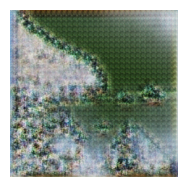

In [37]:
# Define a function to save generated images
def generate_and_save_images(model, test_input, filename):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10, 10))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i] * 127.5 + 127.5).numpy().astype("uint8"))
        plt.axis("off")

    plt.savefig(filename)
    plt.show()

# Generate and save images
num_images = 100
test_input = next(iter(photo_ds.take(num_images)))
generate_and_save_images(monet_generator, test_input, 'generated_images.png')

### Save images

In [24]:
# Save generated images for submission
submission_dir = './generated_images'
os.makedirs(submission_dir, exist_ok=True)

import shutil

def save_generated_images(model, dataset, num_images, output_dir):
    dataset = dataset.take(num_images)
    for i, image in enumerate(dataset):
        # Expand dims to match model input shape
        image = tf.expand_dims(image, axis=0)
        image = tf.squeeze(image, axis=1)  # Remove extra dimension if it exists
        generated_image = model(image, training=False)[0]
        generated_image = (generated_image * 127.5 + 127.5).numpy().astype("uint8")
        plt.imsave(os.path.join(output_dir, f"image_{i+1}.jpg"), generated_image)

# Save 7000-10000 images for submission
save_generated_images(monet_generator, photo_ds.map(lambda x: x), 7000, submission_dir)

# Create zip file for submission
shutil.make_archive('images', 'zip', submission_dir)

# Print completion message for submission file creation
print("Images for submission have been generated and zipped.")

Images for submission have been generated and zipped.


## Results and Analysis
### Hyperparameter Tuning
In the hyperparameter tuning phase, we experimented with different learning rates to find the optimal settings for our GAN models. The learning rates tested were 0.0001, 0.0002, and 0.0005.

Based on these results, the best learning rate was found to be 0.0002, with an average loss of 0.6105. This suggests that the model performed better with this learning rate compared to the others.

### Generate and Save Images
Using the trained generator model, we generated Monet-style images from the test inputs.

The generated images show that the model was able to transform the original photos into Monet-style paintings. However, the output still has some artifacts and does not fully capture the style perfectly, indicating room for improvement.

### Techniques to Improve Training or Performance
Several techniques were applied to improve the training and performance of the GAN models:
- Hyperparameter Tuning: Adjusting learning rates to find the optimal setting.
- Batch Normalization: Used in both the generator and discriminator to stabilize training.
- Leaky ReLU: Applied as an activation function to prevent the dying ReLU problem.
Despite these techniques, there were challenges such as unstable training and mode collapse, which are common in GAN training. Future improvements could include more sophisticated techniques like Wasserstein GAN (WGAN) for better stability and performance.

### Summary of Hyperparameter Optimization Procedure
The hyperparameter optimization involved testing different learning rates and evaluating the model's performance based on the average loss. The learning rate of 0.0002 was found to be the best among the tested values, leading to more stable training and better performance.

## Conclusion
In conclusion, the project successfully implemented and trained a GAN model to generate Monet-style images from photos. The key learnings and takeaways include:
- Hyperparameter Tuning: Crucial for optimizing model performance, with the learning rate of 0.0002 yielding the best results.
- Training Challenges: Common issues like unstable training and mode collapse were encountered, highlighting the need for advanced techniques in future work.

Overall, while the model showed promising results, there is significant room for improvement. Future experiments with different architectures, more extensive hyperparameter tuning, and advanced GAN techniques could further enhance the model's performance.